In [1]:
import torch
import os
import pickle
import gym
import numpy as np
from torch import nn
from environment import GridEnv

In [2]:
checkpoint = torch.load('../../../../Downloads/best_model/policy.pth', map_location=torch.device('cpu'))

In [3]:
class MyModel(nn.Module):
    def __init__(self, observation_space, features_dim: int = 512):
        super(MyModel, self).__init__()
        # We assume CxHxW images (channels first)
        n_input_channels = 5
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )
        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]
        # Latent vector
        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim))

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(features_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 36),
            nn.Softmax(1),
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(features_dim, 64), 
            nn.ReLU(),
        )
        self.V = nn.Linear(64, 1)

        # Subaction logits
        self.action_net = nn.Sequential(
                nn.Linear(36, 177),
                nn.Sigmoid()
            )

    def forward(self, x):
        latent = self.linear(self.cnn(x))
        probs = self.policy_net(latent)
        policy = self.action_net(probs)
        value = self.V(self.value_net(latent))
        return policy, probs, value

In [4]:
from collections import OrderedDict
od = OrderedDict()
for k, v in checkpoint.items():
    if 'features_extractor.' in k:
        od[k.replace('features_extractor.', '')] = v
    elif 'mlp_extractor.' in k:
        od[k.replace('mlp_extractor.', '')] = v
    elif k.startswith('value_net'):
        od[k.replace('value_net.', 'V.')] = v
    else:
        od[k] = v

In [16]:
selections = []
rewards = []
for seed in [42, 1, 90]:    
    env = GridEnv(seed = seed)
    net = MyModel(env.observation_space)
    net.load_state_dict(od)
    net.eval()
    for i in range(10):
        obs = env.reset()
        mask = torch.as_tensor(env.actuator.mask)
        reward = 0
        done = False
        while not done:
            probs, p, _ = net(torch.as_tensor(obs)[None])
            substation = torch.multinomial(p, 1).item()
            p_objects = probs * mask[substation, :]
            action = torch.bernoulli(p_objects).detach().numpy()[0]
            obs, r, done, _ = env.step(action)
            selections.append(substation)
            reward += r
        rewards.append(reward)
        print(reward)
    print('Mean reward. ', np.mean(rewards))

25.336982488632202
13.050065040588379
4.7016648054122925
29.699761509895325
-1.0
1.8415354490280151
13.631643772125244
1.9290415048599243
32.6223578453064
4.671126484870911
Mean reward.  12.648417890071869
1.8351080417633057
-1.0
4.084090828895569
-1.0
-1.0
10.474327087402344
-1.0
-1.0
5.483372092247009
4.6402528285980225
Mean reward.  7.400066488981247
13.417008638381958
7.3912270069122314
-0.29331958293914795
-1.0
-1.0
4.687533259391785
5.476511836051941
7.894920587539673
31.92615807056427
13.205492496490479
Mean reward.  7.656895403067271


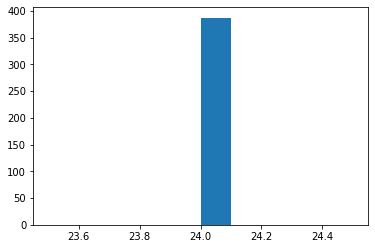

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(selections)
plt.show()

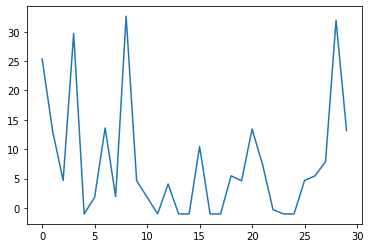

In [18]:
plt.plot(rewards)